## Installation

Create .env file in the project root with the variables:

```
BITQUERY_API_KEY=...
CRYPTORANK_API_KEY=...
```

Get Bitquery API key from https://ide.bitquery.io/

Get Cryptorank API key from https://cryptorank.io/api

Run the following install packages before run
* pip install wordcloud
* pip install pandas
* pip install python-dotenv



# Blockchain as Database

* ## Open ( - source, - data )
* ## Decentralized, eventual-consistent
* ## Ordering achieved by consensus ( Proof-of-work and others )
* ## Cryptographically proven
* ## Driven by protocols

In [32]:
%load_ext dotenv
%dotenv
import os
import requests
import json
from datetime import datetime
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def graphql(url, query, variables={}):
    headers = {
       'Content-Type': 'application/json',
       'X-API-KEY': os.getenv('BITQUERY_API_KEY')
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps({"query": query, "variables": json.dumps(variables)}))
    if response.status_code!=200:
        raise Exception("Error query graphQL:"+str(response.status_code))
    response_json = json.loads(response.text)
    if 'errors' in response_json:
        raise Exception("Errors in graphQL response:"+response.text)
    return response_json['data']

def convert_date(d):
    return datetime.strptime(d['date'], '%Y-%m-%d')

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [6]:
def price(currency, from_date, to_date, convert='USD'):
    url = "https://api.cryptorank.io/v1/currencies/"+currency+"/sparkline?api_key="+os.getenv('CRYPTORANK_API_KEY')+"&from="+from_date + "&to="+to_date+"&interval=1d&convert="+convert
    response = requests.request("GET", url)
    if response.status_code!=200:
        raise Exception("Error query:"+str(response.status_code) + ","+response.text)
    response_json = json.loads(response.text)
    price_data = response_json['data']
    pricedf = pd.DataFrame({'date': price_data['dates'], 'price': price_data['prices']})
    pricedf['date'] = pricedf['date'].apply(convert_datetime)
    pricedf.set_index(['date'],inplace=True)
    return pricedf


def convert_datetime(d):
    return datetime.strptime(d, '%Y-%m-%dT00:00:00.000Z')

def convert_mc(d):
    return d['USD']['marketCap']

def marketcaps():
    url = "https://api.cryptorank.io/v1/currencies"+"?api_key="+os.getenv('CRYPTORANK_API_KEY')
    response = requests.request("GET", url)
    if response.status_code!=200:
        raise Exception("Error query:"+str(response.status_code) + ","+response.text)
    response_json = json.loads(response.text)
    cur_data = response_json['data']
    curdf = pd.DataFrame(cur_data)
    curdf['marketCap'] = curdf['values'].apply(convert_mc)
    curdf.set_index(['slug'],inplace=True)
    return curdf


In [7]:
data = graphql("https://graphql.bitquery.io", """{
  bitcoin {
    transactions {
      date{
        date
      }
      count
    }
  }
}""")
df = pd.DataFrame(data['bitcoin']['transactions'])
df['date'] = df['date'].apply(convert_date)
df.set_index(['date'],inplace=True)

pricedf = price('1','2010-01-01','2023-03-21')

<Axes: >

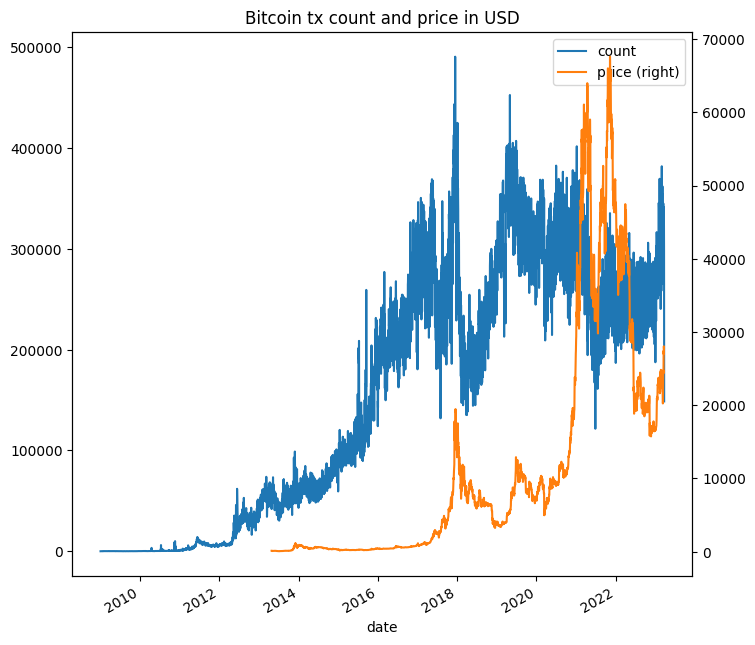

In [8]:
combined = df.plot(figsize=(8,8), title = 'Bitcoin tx count and price in USD')
pricedf.plot(ax = combined, secondary_y=True)

In [9]:
data = graphql("https://graphql.bitquery.io", """{
  ethereum {
    transactions {
      date{
        date
      }
      count
    }
  }
}""")
df = pd.DataFrame(data['ethereum']['transactions'])
df['date'] = df['date'].apply(convert_date)
df.set_index(['date'],inplace=True)

pricedf = price('3','2010-01-01','2023-03-21')

<Axes: >

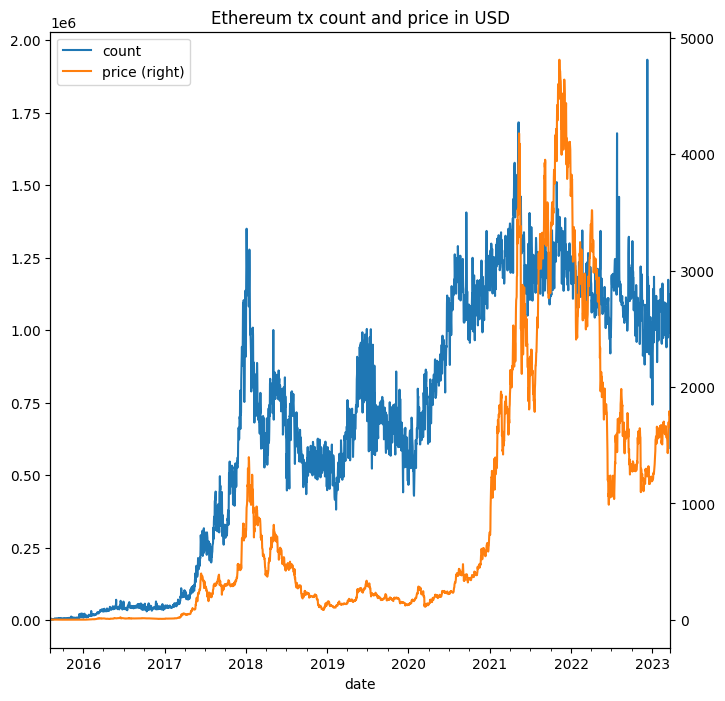

In [10]:
combined = df.plot(figsize=(8,8), title = 'Ethereum tx count and price in USD')
pricedf.plot(ax = combined, secondary_y=True)

(17181.0, 18078.0)

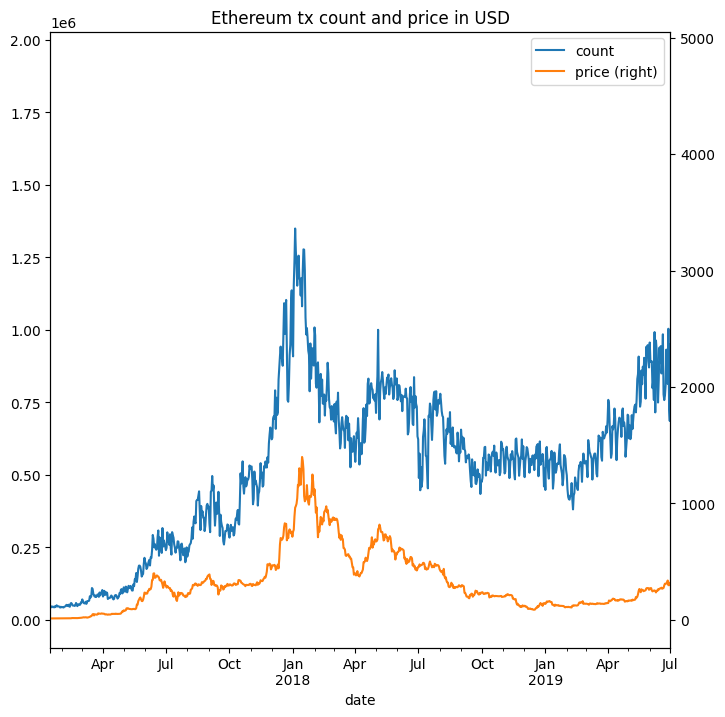

In [11]:
combined = df.plot(figsize=(8,8), title = 'Ethereum tx count and price in USD')
pricedf.plot(ax = combined, secondary_y=True)
combined.set_xlim(pd.Timestamp('2017-01-15'), pd.Timestamp('2019-07-01'))

In [12]:
def tx_by_day(dataset, network, args = ''):
    query = """{{
              {dataset}(network: {network}) {{
                transactions{args} {{
                  date{{
                    date
                  }}
                  {network}: count
                }}
              }}
            }}""".format(dataset = dataset, network = network,args=args )
    data = graphql("https://graphql.bitquery.io", query)
    df = pd.DataFrame(data[dataset]['transactions'])
    df['date'] = df['date'].apply(convert_date)
    df.set_index(['date'],inplace=True)
    return df

In [13]:
ethereum_tx = tx_by_day("ethereum","ethereum")
bsc_tx = tx_by_day("ethereum","bsc")
bitcoin_tx = tx_by_day("bitcoin","bitcoin")
litecoin_tx = tx_by_day("bitcoin","litecoin")
dash_tx = tx_by_day("bitcoin","dash")
zcash_tx = tx_by_day("bitcoin","zcash")
dogecoin_tx = tx_by_day("bitcoin","dogecoin")
terra_tx = tx_by_day("cosmos","terra")
bitcoinsv_tx = tx_by_day("bitcoin","bitcoinsv")
hedera_tx = tx_by_day("hedera","hedera")
matic_tx = tx_by_day("ethereum","matic")
tron_tx = tx_by_day("tron","tron",'(date: {after: "2010-01-01"})')
eos_tx = tx_by_day("eos","eos")
klaytn_tx = tx_by_day("ethereum","klaytn")

In [14]:
solana_tx1 = tx_by_day("solana","solana",'(date: {after: "2023-01-01"})')

In [15]:
solana_tx2 = tx_by_day("solana","solana",'(date: {between: ["2022-10-01","2022-12-31"]})')

In [16]:
solana_tx3 = tx_by_day("solana","solana",'(date: {between: ["2022-07-01","2022-09-30"]})')

In [17]:
solana_tx4 = tx_by_day("solana","solana",'(date: {between: ["2022-01-01","2022-06-30"]})')

In [18]:
solana_tx5 = tx_by_day("solana","solana",'(date: {between: ["2021-06-01","2021-12-31"]})')

In [19]:
solana_tx6 = tx_by_day("solana","solana",'(date: {between: ["2010-01-01","2021-05-31"]})')

In [20]:
solana_tx = pd.concat([solana_tx1,solana_tx2,solana_tx3,solana_tx4,solana_tx5,solana_tx6])

<Axes: title={'center': 'Transactions count by day'}, xlabel='date', ylabel='transactions by day'>

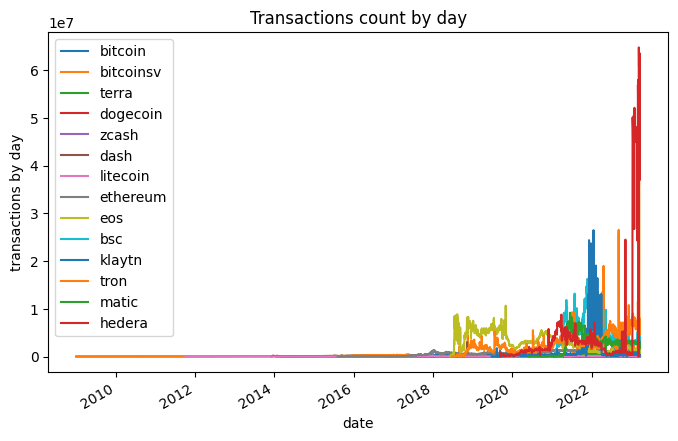

In [174]:
combined = bitcoin_tx.plot(figsize=(8,5), title = 'Transactions count by day', ylabel = "transactions by day")

bitcoinsv_tx.plot(ax = combined)
terra_tx.plot(ax = combined)
dogecoin_tx.plot(ax = combined)
zcash_tx.plot(ax = combined)
dash_tx.plot(ax = combined)
litecoin_tx.plot(ax = combined)
ethereum_tx.plot(ax = combined)
eos_tx.plot(ax = combined)
bsc_tx.plot(ax = combined)
klaytn_tx.plot(ax = combined)
tron_tx.plot(ax = combined)
matic_tx.plot(ax = combined)
hedera_tx.plot(ax = combined)
#solana_tx.plot(ax = combined)



<Axes: title={'center': 'Transactions count by day'}, xlabel='date', ylabel='transactions by day'>

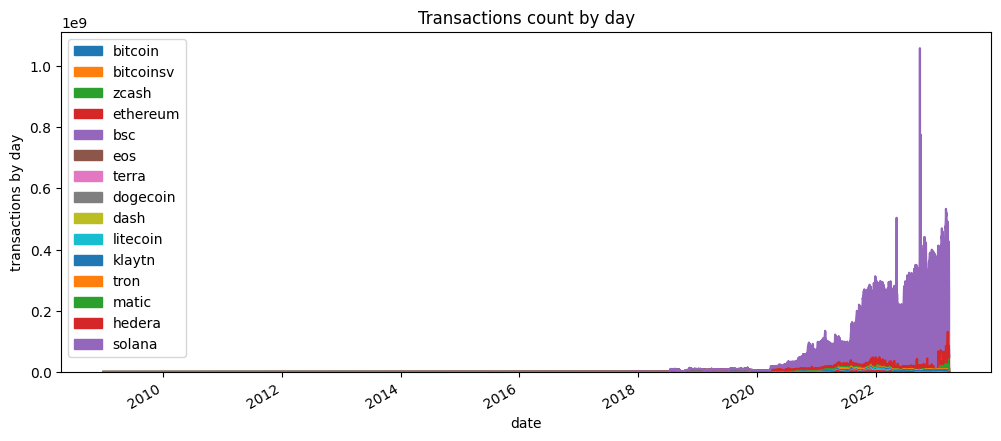

In [183]:
all_blockchains = bitcoin_tx.merge(bitcoinsv_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(zcash_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(ethereum_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(bsc_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(eos_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(terra_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(dogecoin_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(dash_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(litecoin_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(klaytn_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(tron_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(matic_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(hedera_tx, on='date', how='left')
all_blockchains = all_blockchains.merge(solana_tx, on='date', how='left')


all_blockchains.plot.area(stacked = True, figsize=(12,5), title = 'Transactions count by day', ylabel = "transactions by day")

<h3>Internet stats</h3>
<a href="https://www.statista.com/statistics/273018/number-of-internet-users-worldwide/" rel="nofollow"><img src="https://www.statista.com/graphic/1/273018/number-of-internet-users-worldwide.jpg" alt="Statistic: Number of internet users worldwide from 2005 to 2022 (in millions) | Statista" style="width: 100%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a><br />Find more statistics at  <a href="https://www.statista.com" rel="nofollow">Statista</a>

In [23]:
summary = all_blockchains.sum().sort_values()
summary

zcash        1.254583e+07
dash         4.692173e+07
dogecoin     9.462665e+07
litecoin     1.479182e+08
terra        2.080776e+08
bitcoin      8.168297e+08
klaytn       1.577527e+09
bitcoinsv    1.690112e+09
ethereum     1.912131e+09
matic        2.570726e+09
bsc          4.040277e+09
tron         5.128974e+09
eos          5.365806e+09
hedera       5.765219e+09
dtype: float64

<Axes: title={'center': 'Currency market cap'}, xlabel='slug'>

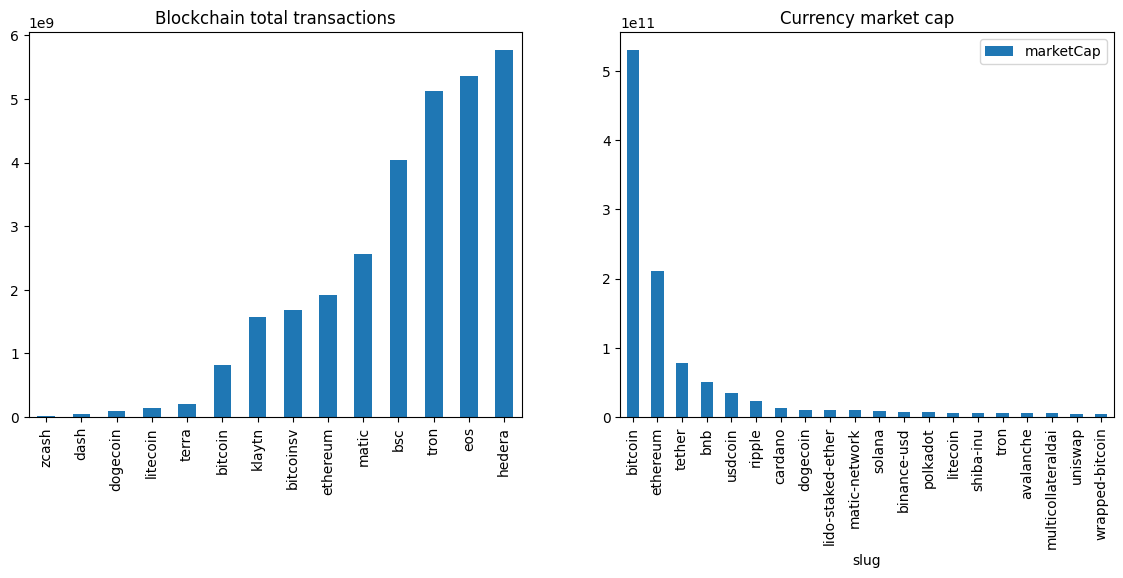

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2)
summary.plot.bar(title = 'Blockchain total transactions', logy = False, ax = axes[0])
mcaps = marketcaps()
sorted_mcaps = mcaps.sort_values('marketCap', ascending = False).head(20)
sorted_mcaps.plot.bar(figsize=(14,5), title = 'Currency market cap', logy = False, y = 'marketCap', ax = axes[1])

In [27]:
monthly = graphql("https://graphql.bitquery.io", """{
  ethereum {
  	transfers {
      users: count(uniq: senders)
      date {
        date(format: "%Y-%m-01")
      }
    }
  }
}""")
monthlydf = pd.DataFrame(monthly['ethereum']['transfers'])
monthlydf['date'] = monthlydf['date'].apply(convert_date)
monthlydf.set_index(['date'],inplace=True)

In [28]:
monthly_scs = graphql("https://graphql.bitquery.io", """{
  ethereum {
  	smartContractCalls {
      smart_contracts: count(uniq: smart_contracts)
      date {
        date(format: "%Y-%m-01")
      }
    }
  }
}""")
monthly_scsdf = pd.DataFrame(monthly_scs['ethereum']['smartContractCalls'])
monthly_scsdf['date'] = monthly_scsdf['date'].apply(convert_date)
monthly_scsdf.set_index(['date'],inplace=True)

<Axes: title={'center': 'Uniques by day'}, xlabel='date', ylabel='uniq'>

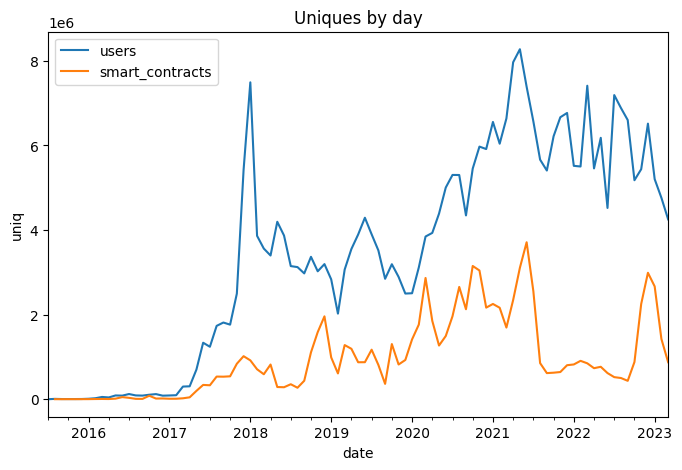

In [29]:
combined_uniq = monthlydf.plot(figsize=(8,5), title = 'Uniques by day', ylabel = "uniq")
monthly_scsdf.plot(ax = combined_uniq)

In [140]:

blockchain_stat = pd.DataFrame([
                                    ["Blockchain", 1, '-', 100 , 10, '-', 10],
                                    ["Internet", '?', 100, 5000 , '-', 1000 ,  5000],
                               ], 
                               columns=['Ecosystem','Daily Transactions, Billions',
                                        'Daily Page Views, Billions', 'Monthly Users, Millions', 
                                        'Monthly Smart Contracts, Millions', 
                                        'Monthly Used Web Sites, Millions', 'Data Size, Petabytes']).transpose()

blockchain_stat_style = blockchain_stat.style.set_properties(**{
    'font-size': '20pt',
})
blockchain_stat_style

,0,1
Ecosystem,Blockchain,Internet
"Daily Transactions, Billions",1,?
"Daily Page Views, Billions",-,100
"Monthly Users, Millions",100,5000
"Monthly Smart Contracts, Millions",10,-
"Monthly Used Web Sites, Millions",-,1000
"Data Size, Petabytes",10,5000


In [129]:
def popular_methods(year):
    
    methods_2023 = graphql("https://graphql.bitquery.io", """query {{
      ethereum {{
        smartContractEvents(
          options: {{desc: "count" limit: 100}}
          date: {{between: ["{year}-01-01","{year}-03-31"]}}) {{
          count
          smartContractEvent {{
            name
          }}
        }}
      }}
    }}""".format(year=year))

    methods_2023_df = pd.DataFrame(methods_2023['ethereum']['smartContractEvents'])
    methods_2023_df['method'] = methods_2023_df['smartContractEvent'].apply(lambda x :  x['name'] or 'unknown'  )
    methods_2023_df.set_index(['method'],inplace=True)
    return methods_2023_df.to_dict()['count']


# 2017

(-0.5, 699.5, 399.5, -0.5)

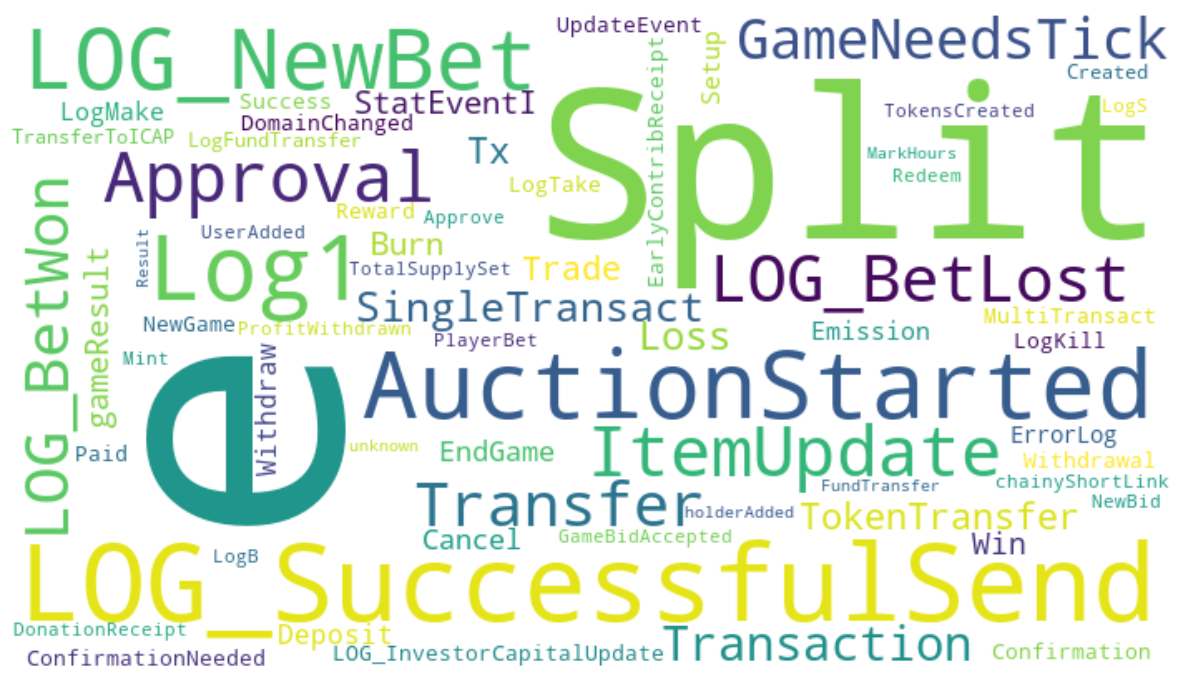

In [163]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white",   width=700, height=400)
wc.generate_from_frequencies(popular_methods(2017))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# 2018

(-0.5, 699.5, 499.5, -0.5)

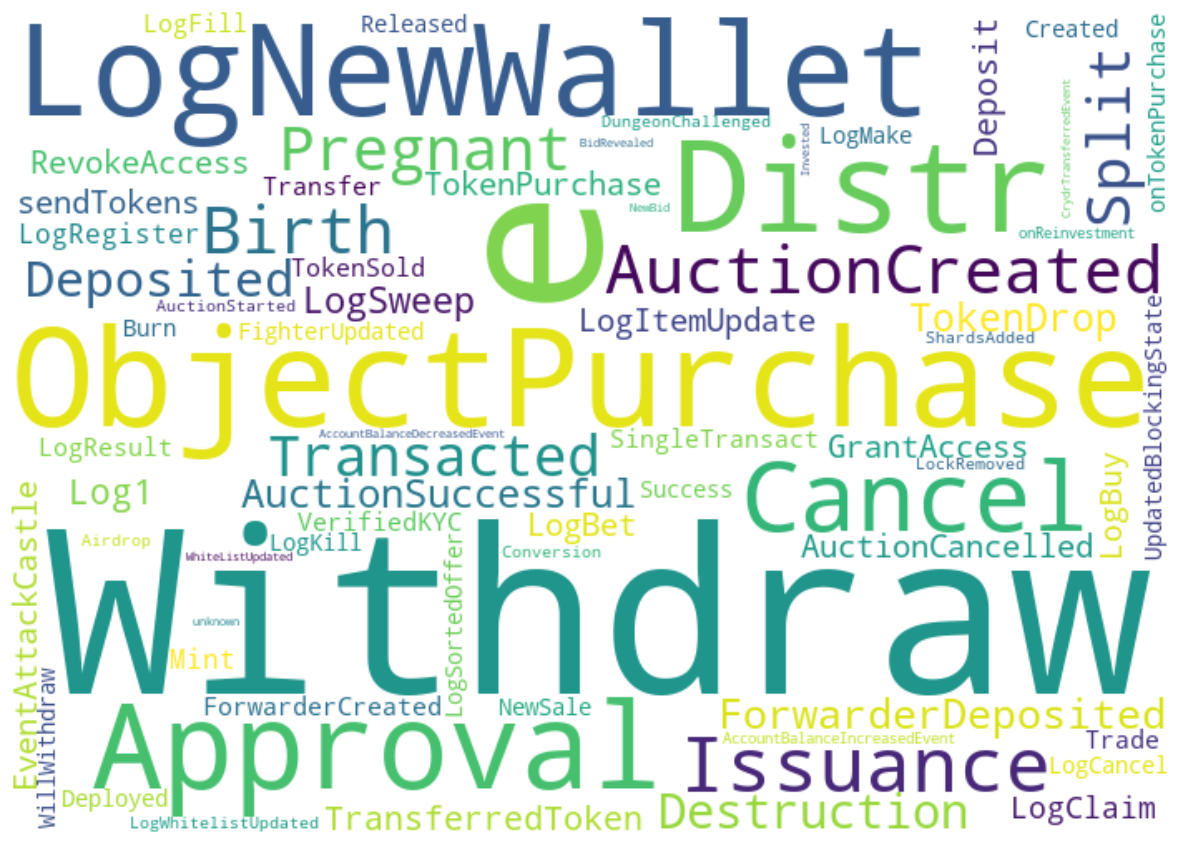

In [98]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white",  width=700, height=500)
wc.generate_from_frequencies(popular_methods(2018))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# 2022

(-0.5, 699.5, 399.5, -0.5)

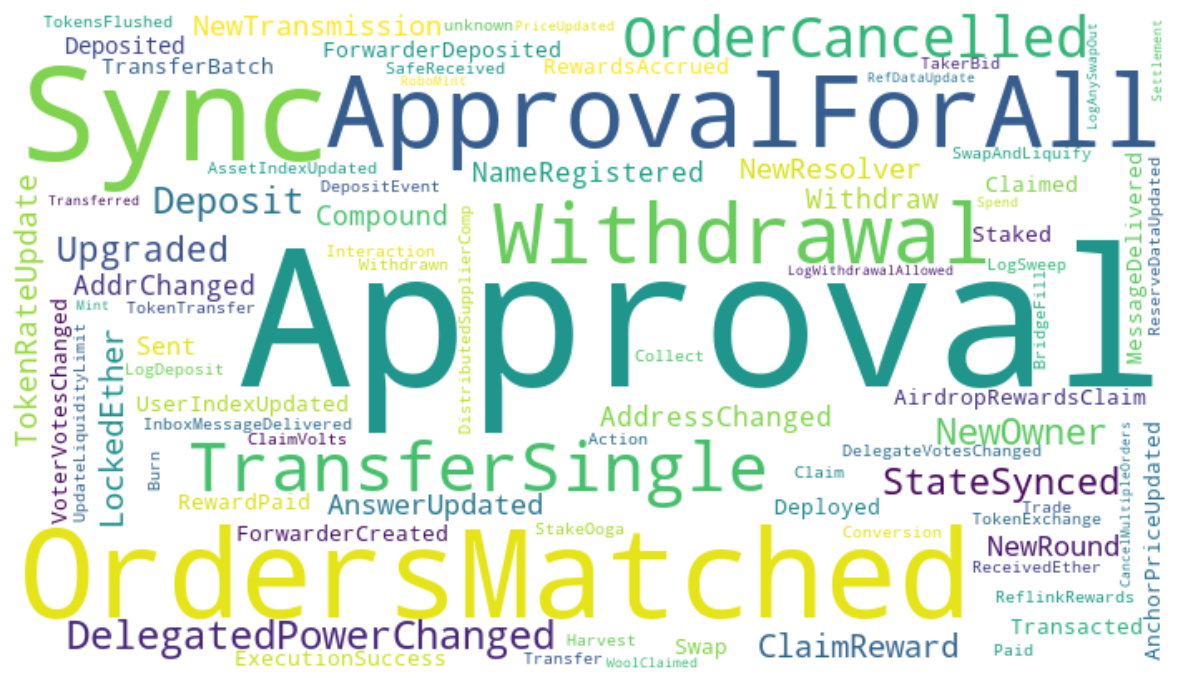

In [165]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white", width=700, height=400)
wc.generate_from_frequencies(popular_methods(2022))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# 2023

(-0.5, 699.5, 399.5, -0.5)

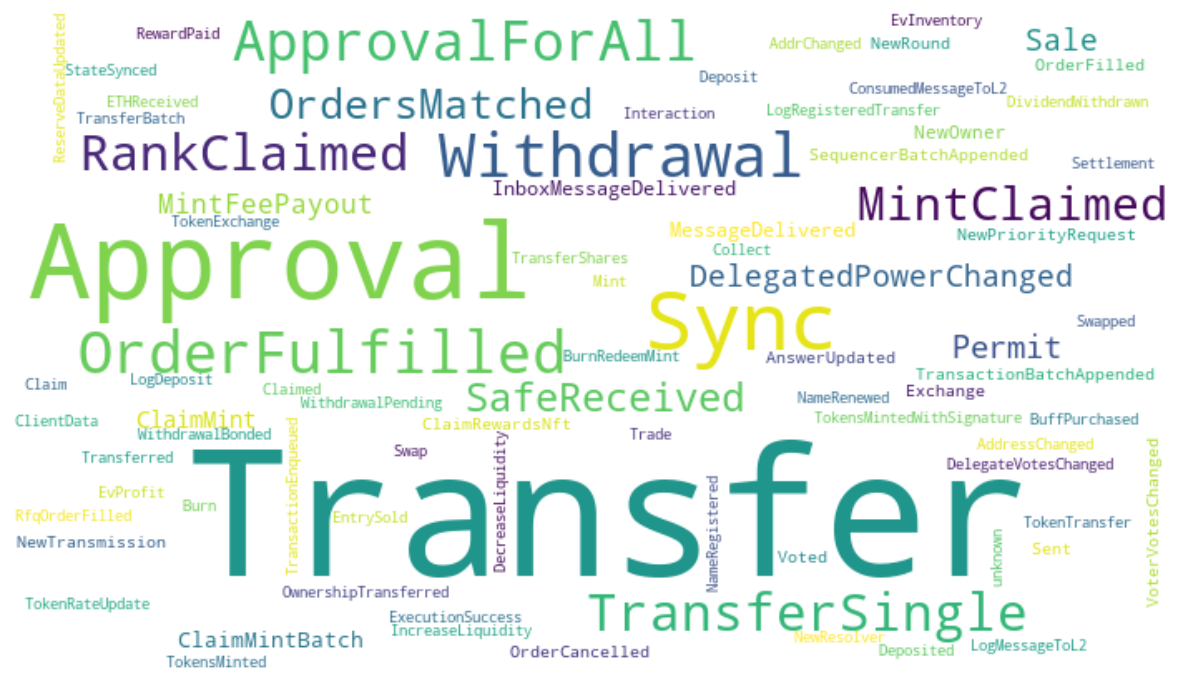

In [164]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white", width=700, height=400)
wc.generate_from_frequencies(popular_methods(2023))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

In [161]:
def gas_methods(year):
    
    methods_2023 = graphql("https://graphql.bitquery.io", """query {{
      ethereum {{
        smartContractCalls(
          options: {{desc: "count" limit: 100}}
          date: {{between: ["{year}-01-01","{year}-03-31"]}}) {{
          count
          gasValue
          smartContractMethod {{
            name
          }}
        }}
      }}
    }}""".format(year=year))

    methods_2023_df = pd.DataFrame(methods_2023['ethereum']['smartContractCalls'])
    methods_2023_df['method'] = methods_2023_df['smartContractMethod'].apply(lambda x :  x['name'] or 'unknown'  )
    methods_2023_df['avgGas'] = methods_2023_df.apply(lambda x :  int(10000000*float(x['gasValue'])/float(x['count']))  , axis=1)
    methods_2023_df.set_index(['method'],inplace=True)
    return methods_2023_df.to_dict()['avgGas']

(-0.5, 699.5, 399.5, -0.5)

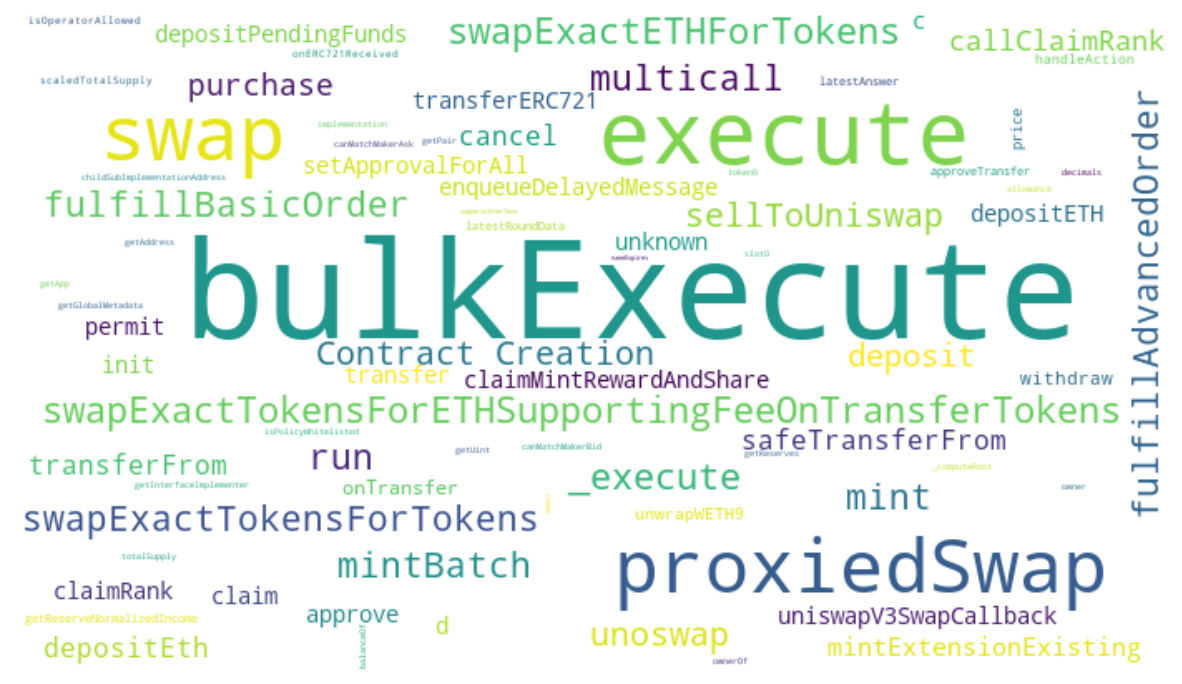

In [166]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white", width=700, height=400)
wc.generate_from_frequencies(gas_methods(2023))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

<Axes: title={'center': 'DEX Trades daily in ethereum mainnet'}, xlabel='date'>

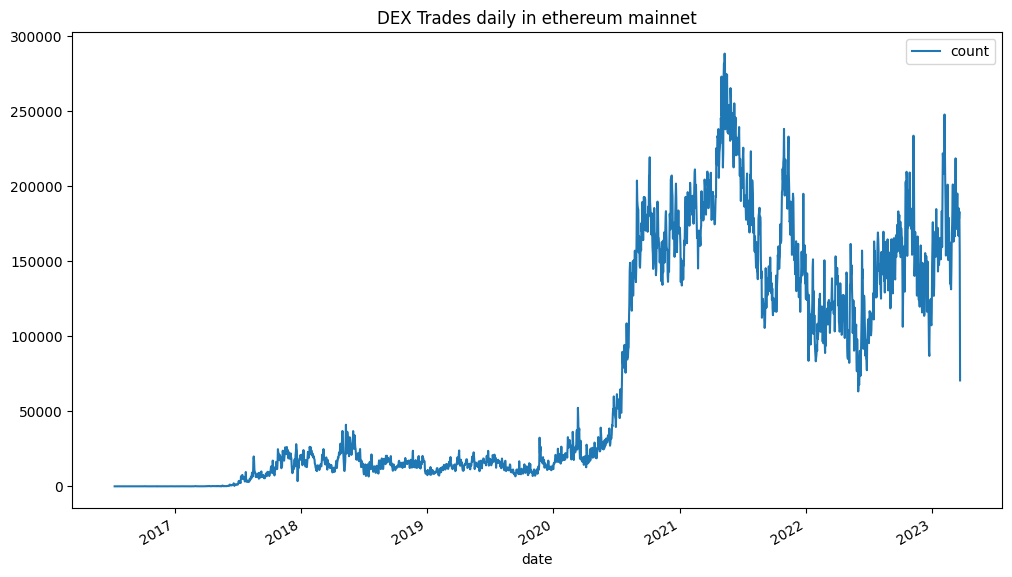

In [168]:
monthly_dex = graphql("https://graphql.bitquery.io", """{
  ethereum {
    dexTrades {
      date {
        date
      }
      count
    }
  }
}""")
monthly_dexdf = pd.DataFrame(monthly_dex['ethereum']['dexTrades'])
monthly_dexdf['date'] = monthly_dexdf['date'].apply(convert_date)
monthly_dexdf.set_index(['date'],inplace=True)
monthly_dexdf.plot(figsize=(12,7),title='DEX Trades daily in ethereum mainnet')

In [113]:
nft_tokens = graphql("https://streaming.bitquery.io/graphql", """{
  EVM(network: eth dataset: archive) {
    nft_transfers: Transfers(where: {Transfer: {Currency: {Fungible: false}}}) {
      count
      Block {
        Date
      }
    }
    token_transfers: Transfers(where: {Transfer: {Currency: {Fungible: true Native: false}}}) {
      count
      Block {
        Date
      }
    }
  }
}""")

<Axes: title={'center': 'Token transfers by day'}, xlabel='date', ylabel='transfer daily'>

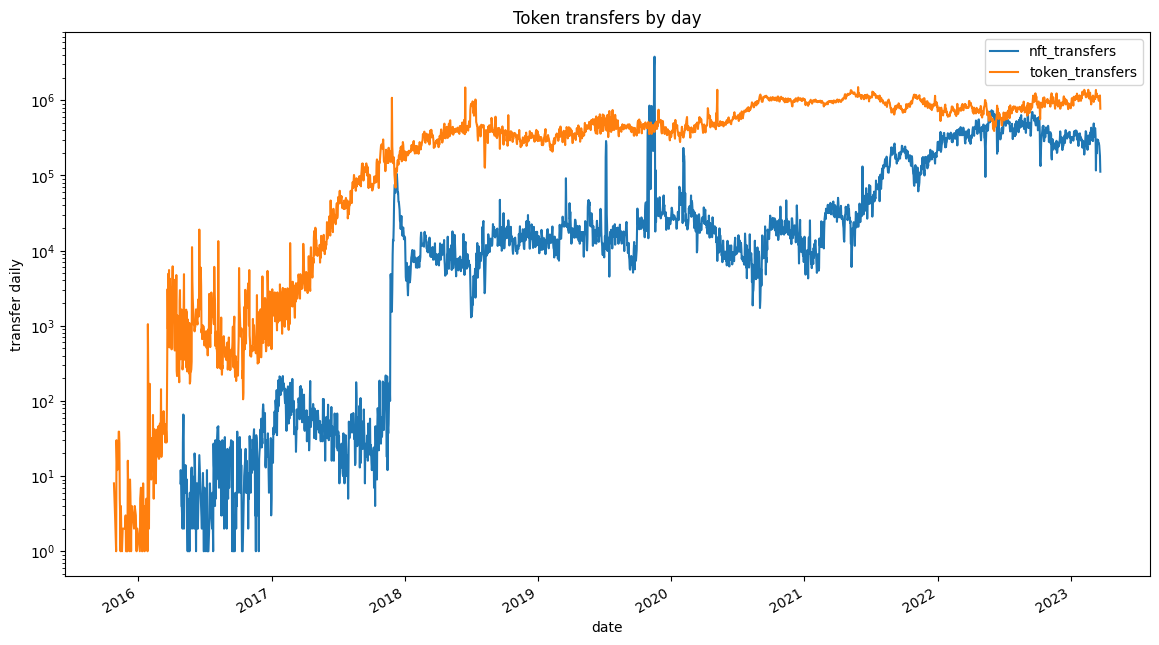

In [170]:
nftdf = pd.DataFrame(nft_tokens['EVM']['nft_transfers'])
nftdf['date'] = nftdf['Block'].apply(lambda x : datetime.strptime(x['Date'], '%Y-%m-%d'))
nftdf['nft_transfers'] = nftdf['count'].apply(lambda x : int(x))
nftdf.set_index(['date'],inplace=True)

erc20df = pd.DataFrame(nft_tokens['EVM']['token_transfers'])
erc20df['date'] = erc20df['Block'].apply(lambda x : datetime.strptime(x['Date'], '%Y-%m-%d'))
erc20df['token_transfers'] = erc20df['count'].apply(lambda x : int(x))
erc20df.set_index(['date'],inplace=True)

combined_tokens = nftdf.plot(figsize=(14,8), title = 'Token transfers by day', ylabel = "transfer daily", logy = True)
erc20df.plot(ax = combined_tokens)


<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/1.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/2.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/3.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/4.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/5.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/6.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/7.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/8.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/9.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/10.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/11.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/12.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/13.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/14.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/15.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/16.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/17.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/18.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/19.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/20.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/21.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/22.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/23.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/24.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/25.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/26.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/27.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/28.png"></img>
<img width="100" height="100" src="https://img.cryptokitties.co/0x06012c8cf97bead5deae237070f9587f8e7a266d/29.png"></img>